# Sélection des hyper-paramètres

Le modèle des plus proches voisins [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) est paramétrable. Le nombre de voisins est variables, la prédiction peut dépendre du plus proche voisins ou des $k$ plus proches proches. Comment choisir $k$ ? 

In [1]:
%matplotlib inline

In [3]:
from teachpyx.datasets import load_wines_dataset

df = load_wines_dataset()

In [4]:
import numpy.random as rnd

index = list(df.index)
rnd.shuffle(index)
df_alea = df.iloc[index, :].reset_index(drop=True)
X = df_alea.drop(["quality", "color"], axis=1)
y = df_alea["quality"]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

On fait une boucle sur un paramètre.

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

voisins = []
r2s = []
for n in range(1, 10):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    r2 = r2_score(y_test, knn.predict(X_test))
    voisins.append(n)
    r2s.append(r2)

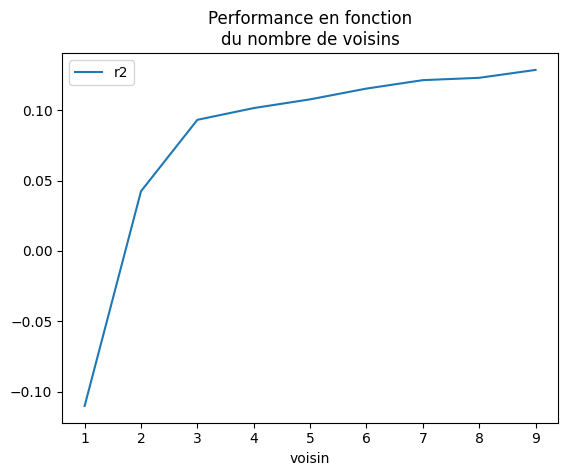

In [7]:
import pandas

df = pandas.DataFrame(dict(voisin=voisins, r2=r2s))
ax = df.plot(x="voisin", y="r2")
ax.set_title("Performance en fonction\ndu nombre de voisins");

La fonction [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) automatise la recherche d'un optimum parmi les hyperparamètre, elle utilise notamment la validation croisée. On teste toutes les valeurs de $k$ de 1 à 20.

In [11]:
parameters = {"n_neighbors": list(range(1, 31, 3))}

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
grid = GridSearchCV(knn, parameters, verbose=2, return_train_score=True)

In [13]:
grid.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END ......................................n

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28]},
             return_train_score=True, verbose=2)

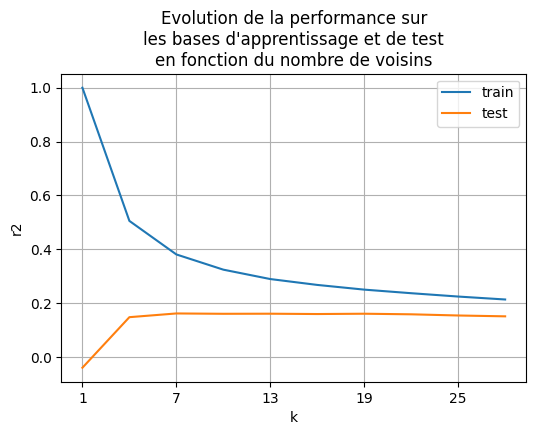

In [14]:
res = grid.cv_results_
k = res["param_n_neighbors"]
train_score = res["mean_train_score"]
test_score = res["mean_test_score"]

import pandas

df_score = pandas.DataFrame(dict(k=k, test=test_score, train=train_score))
ax = df_score.plot(x="k", y="train", figsize=(6, 4))
df_score.plot(x="k", y="test", ax=ax, grid=True)
ax.set_title(
    "Evolution de la performance sur\nles bases d'apprentissage et de test"
    + "\nen fonction du nombre de voisins"
)
ax.set_ylabel("r2");

On voit que le modèle gagne en pertinence sur la base de test et que le nombre de voisins optimal parmi ceux essayés se situe autour de 15.

In [15]:
df_score[12:17]

,k,test,train


L'erreur sur la base d'apprentissage augmente de manière sensible ($R^2$ baisse). Voyons ce qu'il en est un peu plus loin.

In [22]:
parameters = {"n_neighbors": list(range(5, 51, 10)) + list(range(50, 151, 50))}
grid = GridSearchCV(knn, parameters, verbose=2, return_train_score=True)
grid.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.2s
[CV] END .....................................n_neighbors=15; total time=   0.1s
[CV] END .....................................n_neighbors=15; total time=   0.1s
[CV] END .....................................n_neighbors=15; total time=   0.1s
[CV] END .....................................n_neighbors=15; total time=   0.1s
[CV] END .....................................n_neighbors=15; total time=   0.1s
[CV] END .....................................n_neighbors=25; total time=   0.2s
[CV] END .....................................n_n

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 15, 25, 35, 45, 50, 100, 150]},
             return_train_score=True, verbose=2)

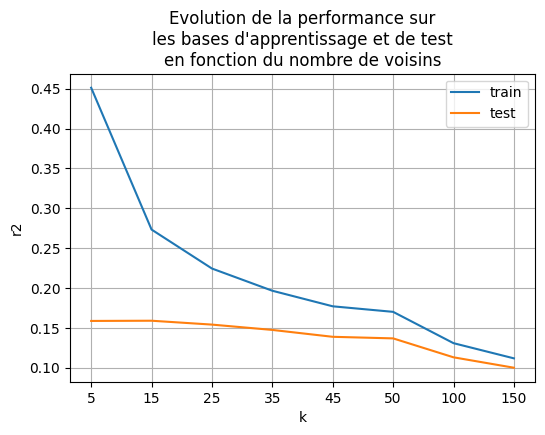

In [23]:
res = grid.cv_results_
k = res["param_n_neighbors"]
train_score = res["mean_train_score"]
test_score = res["mean_test_score"]

import pandas

df_score = pandas.DataFrame(dict(k=k, test=test_score, train=train_score))
ax = df_score.plot(x="k", y="train", figsize=(6, 4))
df_score.plot(x="k", y="test", ax=ax, grid=True)
ax.set_title(
    "Evolution de la performance sur\nles bases d'apprentissage et de test"
    + "\nen fonction du nombre de voisins"
)
ax.set_ylabel("r2");

Après 25 voisins, la pertinence du modèle décroît fortement, ce qui paraît normal car plus il y a de voisins, moins la prédiction est locale en quelque sorte. Pour ce modèle, les plus proches voisins, l'erreur sur la base d'apprentissage ne fait que décroître. $R^2$ est maximal pour $k=1$ puisqu'on prédit avec le plus proche voisin, c'est-à-dire lui-même.